In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np 
import torchvision

In [2]:
!pip install audtorch
from audtorch.metrics.functional import pearsonr as correlation

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [13]:
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(),])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 48, kernel_size=3), nn.ReLU(),
        nn.Conv2d(48, 128, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(128, 96, kernel_size=1, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 10, kernel_size=1), 
        nn.AvgPool2d(kernel_size=8),
    )
  def forward(self, x):
    logits = self.net(x)
    return logits.view(-1, 10)

In [15]:
# Pretrain classifier
classifier = Classifier().cuda()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
for epoch in range(20):
  for i, (x,y) in enumerate(train_loader):
    x, y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    train_loss = loss(classifier(x), y)
    train_loss.backward()
    optimizer.step()
    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Classifier_loss: {}'.format(epoch+1, 20, i+1, len(train_loader), train_loss.item()))

Epoch [1/20], Step [1/391], Classifier_loss: 2.2979183197021484
Epoch [1/20], Step [101/391], Classifier_loss: 1.8788601160049438
Epoch [1/20], Step [201/391], Classifier_loss: 1.855514407157898
Epoch [1/20], Step [301/391], Classifier_loss: 1.762709617614746
Epoch [2/20], Step [1/391], Classifier_loss: 1.5364128351211548
Epoch [2/20], Step [101/391], Classifier_loss: 1.6798217296600342
Epoch [2/20], Step [201/391], Classifier_loss: 1.5436079502105713
Epoch [2/20], Step [301/391], Classifier_loss: 1.3457220792770386
Epoch [3/20], Step [1/391], Classifier_loss: 1.4982850551605225
Epoch [3/20], Step [101/391], Classifier_loss: 1.529322624206543
Epoch [3/20], Step [201/391], Classifier_loss: 1.368506908416748
Epoch [3/20], Step [301/391], Classifier_loss: 1.4156372547149658
Epoch [4/20], Step [1/391], Classifier_loss: 1.3850438594818115
Epoch [4/20], Step [101/391], Classifier_loss: 1.4344526529312134
Epoch [4/20], Step [201/391], Classifier_loss: 1.203646183013916
Epoch [4/20], Step [301

In [16]:
torch.save(classifier.state_dict(), 'pretrained_classifier.pth')

In [17]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy: %s %%' % (100 * correct / total))

In [18]:
accuracy(classifier)

Accuracy: 76.3 %


In [19]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    layers = [
              nn.Conv2d(3, 64, 5, padding=2, stride=2), nn.BatchNorm2d(64, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(64, 128, 5, padding=2, stride=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(128, 256, 5, padding=2, stride=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Flatten(), nn.Linear(256*4*4, 2048), nn.BatchNorm1d(2048, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Linear(2048, 10),
    ]
    self.net = nn.Sequential(*layers)

  def forward(self,x):
    return self.net(x)

In [20]:
enc = Encoder()
rand = torch.randn((64,3,32,32))
enc(rand).shape

torch.Size([64, 10])

In [21]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
              nn.Linear(20, 256*4*4), nn.BatchNorm1d(256*4*4, momentum=0.9), nn.LeakyReLU(0.2),
              )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(256,256,6, stride=2, padding=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(256,128,6, stride=2, padding=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128,32,6, stride=2, padding=2), nn.BatchNorm2d(32, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32,3,5, stride=1, padding=2), nn.Tanh()
    )

  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 256, 4, 4)
    return self.conv(x)

In [22]:
class Generator(nn.Module):
  def __init__(self, epsilon):
    super().__init__()
    self.decoder = Decoder()
    self.encoder = Encoder()
    self.classifier = classifier
    self.epsilon = epsilon
    for param in classifier.parameters():
      param.requires_grad = False

  def loss(self, x, y, gen_labels):
    one_hot = F.one_hot(gen_labels, 10).cuda()
    z = torch.cat((self.encoder(x), one_hot), 1)
    perturbation = epsilon * self.decoder(z)
    logits = self.classifier(x+perturbation)
    predictions = F.softmax(logits, 1)
    loss = nn.CrossEntropyLoss()
    return loss(classifier(x+perturbation), gen_labels), perturbation

In [23]:
epsilon = 0.05
epochs = 10
model = Generator(epsilon).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(epochs):
  for i, (x,y) in enumerate(train_loader):
    x,y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
    loss, perturbation = model.loss(x,y,gen_labels)
    loss.backward()
    optimizer.step()
    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss.item()))

Epoch [1/10], Step [1/391], Loss: 7.09256649017334
Epoch [1/10], Step [101/391], Loss: 2.64104962348938
Epoch [1/10], Step [201/391], Loss: 2.1807754039764404
Epoch [1/10], Step [301/391], Loss: 2.1082851886749268
Epoch [2/10], Step [1/391], Loss: 1.2787988185882568
Epoch [2/10], Step [101/391], Loss: 1.633371114730835
Epoch [2/10], Step [201/391], Loss: 1.7790250778198242
Epoch [2/10], Step [301/391], Loss: 1.2564260959625244
Epoch [3/10], Step [1/391], Loss: 1.0511860847473145
Epoch [3/10], Step [101/391], Loss: 1.3821123838424683
Epoch [3/10], Step [201/391], Loss: 1.4054856300354004
Epoch [3/10], Step [301/391], Loss: 1.0891814231872559
Epoch [4/10], Step [1/391], Loss: 1.1376497745513916
Epoch [4/10], Step [101/391], Loss: 1.0801539421081543
Epoch [4/10], Step [201/391], Loss: 0.9748976826667786
Epoch [4/10], Step [301/391], Loss: 1.119098424911499
Epoch [5/10], Step [1/391], Loss: 0.9192053079605103
Epoch [5/10], Step [101/391], Loss: 1.3901021480560303
Epoch [5/10], Step [201/39

In [24]:
def adv_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
          outputs = net(model.loss(images, labels, gen_labels)[1] + images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Adversarial accuracy: %s %%' % (100 * correct / total))

In [25]:
adv_accuracy(classifier)

Adversarial accuracy: 23.33 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

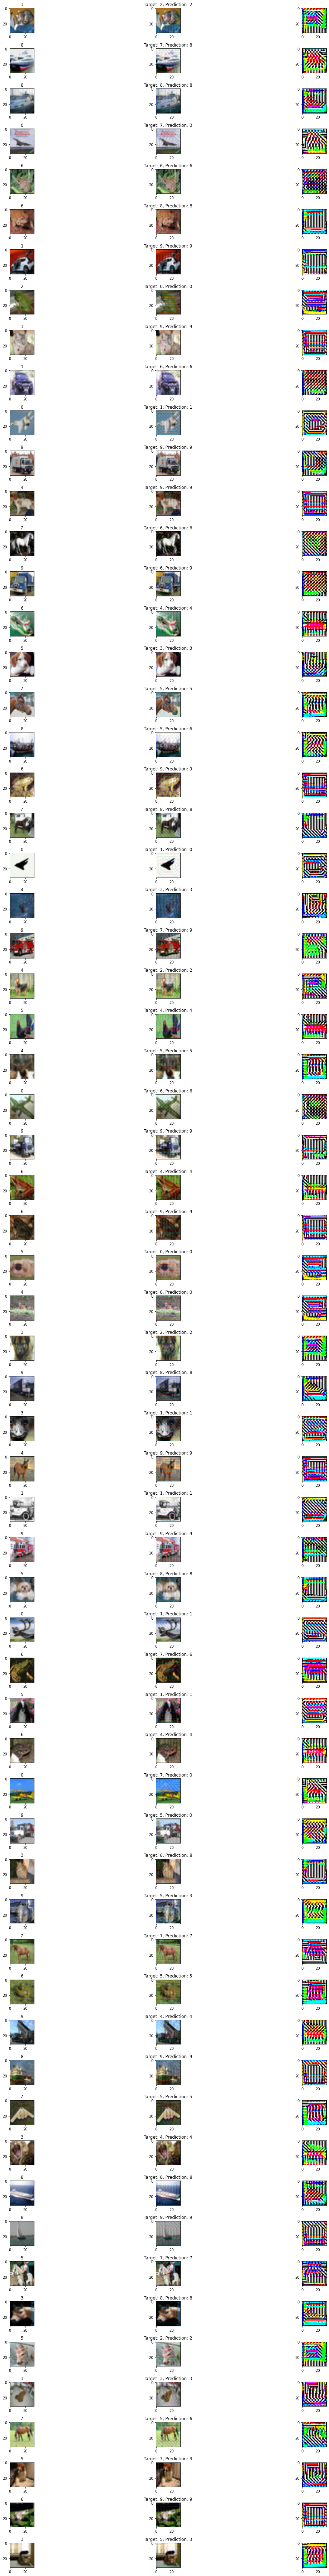

In [31]:
for x,y in test_loader:
  gen_labels = torch.randint(0,10, (128,)).cuda()
  x,y = x.cuda(), y.cuda()
  base_predictions = classifier(x)
  _, perturbations = model.loss(x,y, gen_labels)
  new_predictions = classifier(x+perturbations)
  fig, axs = plt.subplots(64, 3)
  fig.set_figheight(100)
  fig.set_figwidth(20)
  images = []
  for i in range(64):
          image, perturbation = x[i].detach().cpu().numpy().transpose(1,2,0), perturbations[i].detach().cpu().numpy().transpose(1,2,0)
          images.append(axs[i, 0].imshow(image))
          axs[i,0].title.set_text(torch.argmax(base_predictions[i]).item())
          images.append(axs[i,1].imshow(image+perturbation))
          axs[i,1].title.set_text(f'Target: {gen_labels[i]}, Prediction: {torch.argmax(new_predictions[i]).item()}')
          images.append(axs[i,2].imshow(perturbation*20, cmap='gray'))
  break

plt.tight_layout()
plt.show()